In [ ]:
"""
COMPAS Recidivism Dataset Bias Audit
Using AI Fairness 360 to analyze racial bias in risk scores
"""

# Installing Required Packages

print("Installing required packages...")
!pip install aif360 -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q
print("✓ Installation complete!\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# AIF360 imports
from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)



Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 6.2 MB/s eta 0:00:00
✓ Installation complete!



pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
# STEP 1: Load and Explore COMPAS Dataset

import os

# Define the target directory and file URL
COMPAS_DATA_DIR = "/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas"
COMPAS_FILE_URL = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
COMPAS_FILE_PATH = os.path.join(COMPAS_DATA_DIR, "compas-scores-two-years.csv")

# Check if the file already exists to avoid re-downloading
if not os.path.exists(COMPAS_FILE_PATH):
    print("Downloading COMPAS dataset...")
    !mkdir -p {COMPAS_DATA_DIR}
    !wget -q -O {COMPAS_FILE_PATH} {COMPAS_FILE_URL}
    print("✓ COMPAS dataset downloaded successfully!")
else:
    print("✓ COMPAS dataset already exists.")

print("="*80)
print("COMPAS RECIDIVISM DATASET - BIAS AUDIT")
print("="*80)

# Load COMPAS dataset from AIF360
dataset = CompasDataset()
print(f"\n✓ Dataset loaded with {len(dataset.feature_names)} features")
print(f"✓ Protected attribute: {dataset.protected_attribute_names}")
print(f"✓ Favorable label (No Recidivism): {dataset.favorable_label}")
print(f"✓ Unfavorable label (Recidivism): {dataset.unfavorable_label}")

# Convert to pandas DataFrame for easier analysis
df = pd.DataFrame(dataset.features, columns=dataset.feature_names)
df['two_year_recid'] = dataset.labels.ravel()


✓ COMPAS dataset downloaded successfully!
COMPAS RECIDIVISM DATASET - BIAS AUDIT

✓ Dataset loaded with 401 features
✓ Protected attribute: ['sex', 'race']
✓ Favorable label (No Recidivism): 0.0
✓ Unfavorable label (Recidivism): 1.0


In [ ]:


# ====================================
# STEP 2: Analyze Dataset Composition
# ====================================

print("\n" + "="*80)
print("DATASET COMPOSITION")
print("="*80)

# Race distribution
race_col = 'race'
race_counts = df[race_col].value_counts()
print(f"\nRace Distribution:")
print(f"  African-American (0.0): {(df[race_col] == 0.0).sum()} ({(df[race_col] == 0.0).sum()/len(df)*100:.1f}%)")
print(f"  Caucasian (1.0): {(df[race_col] == 1.0).sum()} ({(df[race_col] == 1.0).sum()/len(df)*100:.1f}%)")

print(f"\nRecidivism Rate by Race:")
for race, rate in df.groupby(race_col)['two_year_recid'].mean().items():
    race_name = "African-American" if race == 0.0 else "Caucasian"
    print(f"  {race_name}: {rate:.3f} ({rate*100:.1f}%)")


DATASET COMPOSITION

Race Distribution:
  African-American (0.0): 4067 (65.9%)
  Caucasian (1.0): 2100 (34.1%)

Recidivism Rate by Race:
  African-American: 0.489 (48.9%)
  Caucasian: 0.391 (39.1%)


In [ ]:

# ======================================================
# STEP 3: Calculate Fairness Metrics (Before Mitigation)
# ======================================================

print("\n" + "="*80)
print("FAIRNESS METRICS - ORIGINAL DATASET")
print("="*80)

# Define privileged and unprivileged groups
privileged_groups = [{'race': 1.0}]  # Caucasian
unprivileged_groups = [{'race': 0.0}]  # African-American

# Calculate dataset metrics
metric_orig = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

di = metric_orig.disparate_impact()
spd = metric_orig.statistical_parity_difference()
md = metric_orig.mean_difference()

print(f"\n📊 Disparate Impact: {di:.3f}")
print(f"   → Ideal = 1.0, < 0.8 indicates bias")
print(f"   → Status: {'BIASED' if di < 0.8 else '✓ Fair'}")

print(f"\n📊 Statistical Parity Difference: {spd:.3f}")
print(f"   → Ideal = 0.0, negative = bias against unprivileged")
print(f"   → Status: {'BIASED' if abs(spd) > 0.1 else '✓ Fair'}")

print(f"\n📊 Mean Difference: {md:.3f}")



FAIRNESS METRICS - ORIGINAL DATASET

📊 Disparate Impact: 0.840
   → Ideal = 1.0, < 0.8 indicates bias
   → Status: ✓ Fair

📊 Statistical Parity Difference: -0.097
   → Ideal = 0.0, negative = bias against unprivileged
   → Status: ✓ Fair

📊 Mean Difference: -0.097


In [ ]:

# ===========================================
# STEP 4: Train Classifier and Evaluate Bias
# ===========================================

print("\n" + "="*80)
print("CLASSIFIER PERFORMANCE METRICS")
print("="*80)

# Split dataset
train_dataset, test_dataset = dataset.split([0.7], shuffle=True, seed=42)

# Train a simple logistic regression classifier
scaler = StandardScaler()
X_train = scaler.fit_transform(train_dataset.features)
y_train = train_dataset.labels.ravel()

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions
X_test = scaler.transform(test_dataset.features)
y_pred = clf.predict(X_test)

# Create predicted dataset
test_dataset_pred = test_dataset.copy()
test_dataset_pred.labels = y_pred.reshape(-1, 1)

# Calculate classification metrics
classified_metric = ClassificationMetric(
    test_dataset,
    test_dataset_pred,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

acc = classified_metric.accuracy()
fpr_priv = classified_metric.false_positive_rate(privileged=True)
fpr_unpriv = classified_metric.false_positive_rate(privileged=False)
fpr_disp = fpr_unpriv - fpr_priv

fnr_priv = classified_metric.false_negative_rate(privileged=True)
fnr_unpriv = classified_metric.false_negative_rate(privileged=False)
fnr_disp = fnr_unpriv - fnr_priv

eod = classified_metric.equal_opportunity_difference()
aod = classified_metric.average_odds_difference()

print(f"\n✓ Overall Accuracy: {acc:.3f}")

print(f"\n📈 False Positive Rate:")
print(f"   Caucasian: {fpr_priv:.3f}")
print(f"   African-American: {fpr_unpriv:.3f}")
print(f"   Disparity: {fpr_disp:.3f} ({'Higher for African-Americans' if fpr_disp > 0.05 else '✓ Minimal'})")

print(f"\n📉 False Negative Rate:")
print(f"   Caucasian: {fnr_priv:.3f}")
print(f"   African-American: {fnr_unpriv:.3f}")
print(f"   Disparity: {fnr_disp:.3f}")

print(f"\nEqual Opportunity Difference: {eod:.3f}")
print(f"Average Odds Difference: {aod:.3f}")


CLASSIFIER PERFORMANCE METRICS

✓ Overall Accuracy: 0.664

📈 False Positive Rate:
   Caucasian: 0.578
   African-American: 0.395
   Disparity: -0.183 (✓ Minimal)

📉 False Negative Rate:
   Caucasian: 0.189
   African-American: 0.283
   Disparity: 0.095

⚖️ Equal Opportunity Difference: -0.095
⚖️ Average Odds Difference: -0.139



GENERATING VISUALIZATIONS

✓ Visualization saved as 'compas_bias_audit.png'


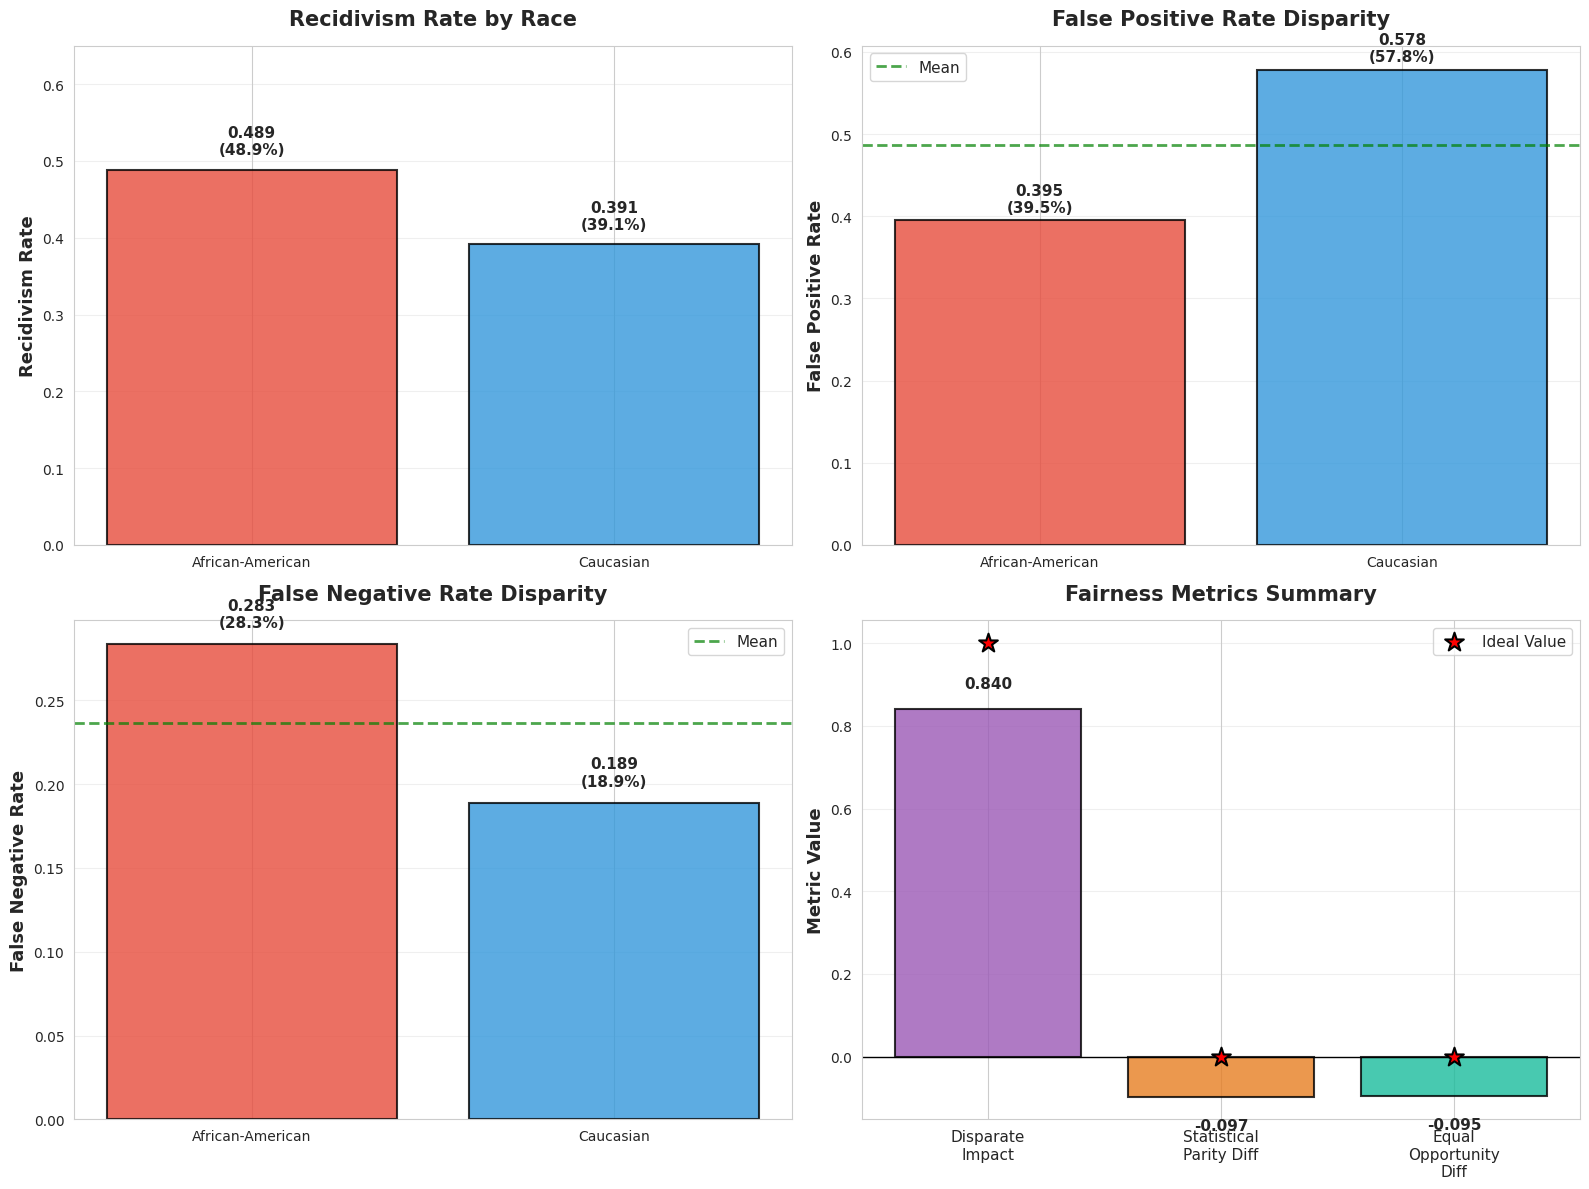

In [ ]:


# ========================
# STEP 5: Visualizations
# ========================

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recidivism Rate by Race
race_labels = ['African-American', 'Caucasian']
recid_rates = [
    df[df[race_col] == 0.0]['two_year_recid'].mean(),
    df[df[race_col] == 1.0]['two_year_recid'].mean()
]
colors = ['#e74c3c', '#3498db']
bars1 = axes[0, 0].bar(race_labels, recid_rates, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 0].set_ylabel('Recidivism Rate', fontsize=13, fontweight='bold')
axes[0, 0].set_title('Recidivism Rate by Race', fontsize=15, fontweight='bold', pad=15)
axes[0, 0].set_ylim(0, 0.65)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(recid_rates):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold', fontsize=11)

# 2. False Positive Rate Comparison
fpr_data = {
    'African-American': fpr_unpriv,
    'Caucasian': fpr_priv
}
bars2 = axes[0, 1].bar(fpr_data.keys(), fpr_data.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0, 1].set_ylabel('False Positive Rate', fontsize=13, fontweight='bold')
axes[0, 1].set_title('False Positive Rate Disparity', fontsize=15, fontweight='bold', pad=15)
axes[0, 1].axhline(y=np.mean(list(fpr_data.values())), color='green', linestyle='--', linewidth=2, label='Mean', alpha=0.7)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(fpr_data.items()):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold', fontsize=11)

# 3. False Negative Rate Comparison
fnr_data = {
    'African-American': fnr_unpriv,
    'Caucasian': fnr_priv
}
bars3 = axes[1, 0].bar(fnr_data.keys(), fnr_data.values(), color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel('False Negative Rate', fontsize=13, fontweight='bold')
axes[1, 0].set_title('False Negative Rate Disparity', fontsize=15, fontweight='bold', pad=15)
axes[1, 0].axhline(y=np.mean(list(fnr_data.values())), color='green', linestyle='--', linewidth=2, label='Mean', alpha=0.7)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)
for i, (k, v) in enumerate(fnr_data.items()):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}\n({v*100:.1f}%)', ha='center', fontweight='bold', fontsize=11)

# 4. Fairness Metrics Summary
metrics_names = ['Disparate\nImpact', 'Statistical\nParity Diff', 'Equal\nOpportunity\nDiff']
metrics_values = [di, spd, eod]
ideal_values = [1.0, 0.0, 0.0]
metric_colors = ['#9b59b6', '#e67e22', '#1abc9c']

x_pos = np.arange(len(metrics_names))
bars4 = axes[1, 1].bar(x_pos, metrics_values, color=metric_colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1, 1].scatter(x_pos, ideal_values, color='red', s=200, marker='*', label='Ideal Value', zorder=5, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('Metric Value', fontsize=13, fontweight='bold')
axes[1, 1].set_title('Fairness Metrics Summary', fontsize=15, fontweight='bold', pad=15)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(metrics_names, fontsize=11)
axes[1, 1].legend(fontsize=11)
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(metrics_values):
    axes[1, 1].text(i, v + 0.05 if v > 0 else v - 0.08, f'{v:.3f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('compas_bias_audit.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'compas_bias_audit.png'")
plt.show()

In [ ]:

# ============================================
# STEP 6: Apply Bias Mitigation (Reweighing)
# ============================================

print("\n" + "="*80)
print("BIAS MITIGATION - REWEIGHING")
print("="*80)

# Apply reweighing preprocessing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

# Calculate metrics after mitigation
metric_transf = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

di_after = metric_transf.disparate_impact()
spd_after = metric_transf.statistical_parity_difference()

print(f"\n📊 BEFORE vs AFTER Mitigation:")
print(f"\nDisparate Impact:")
print(f"   Before: {di:.3f}")
print(f"   After:  {di_after:.3f}")
print(f"   Improvement: {((di_after - di) / di * 100):+.1f}%")

print(f"\nStatistical Parity Difference:")
print(f"   Before: {spd:.3f}")
print(f"   After:  {spd_after:.3f}")
print(f"   Improvement: {abs(spd) - abs(spd_after):+.3f}")



BIAS MITIGATION - REWEIGHING

📊 BEFORE vs AFTER Mitigation:

Disparate Impact:
   Before: 0.840
   After:  1.000
   Improvement: +19.0%

Statistical Parity Difference:
   Before: -0.097
   After:  0.000
   Improvement: +0.097


In [ ]:


# =======================
# STEP 7: Summary Report
# =======================

print("\n" + "="*80)
print("AUDIT SUMMARY")
print("="*80)

summary = f"""
🔍 KEY FINDINGS:

1. Disparate Impact: {di:.3f} (threshold: 0.8)
   {'⚠️ SIGNIFICANT BIAS DETECTED' if di < 0.8 else '✓ Within acceptable range'}

2. False Positive Rate Disparity: {fpr_disp:+.3f}
   African-Americans have {abs(fpr_disp)*100:.1f}% {'higher' if fpr_disp > 0 else 'lower'} FPR
   {'⚠️ CONCERNING DISPARITY' if abs(fpr_disp) > 0.05 else '✓ Minimal disparity'}

3. Statistical Parity Difference: {spd:.3f}
   {'⚠️ Lower favorable outcomes for unprivileged group' if spd < -0.1 else '✓ Relatively balanced'}

4. Equal Opportunity Difference: {eod:.3f}
   {'⚠️ Unequal true positive rates across groups' if abs(eod) > 0.1 else '✓ Acceptable balance'}

⚖️ CONCLUSION: {'SIGNIFICANT racial bias detected in COMPAS risk scores.' if di < 0.8 or abs(spd) > 0.1 else 'Some bias indicators present but within acceptable thresholds.'}

✅ MITIGATION RESULTS:
   Reweighing improved Disparate Impact by {((di_after - di) / di * 100):.1f}%
   Statistical Parity improved by {abs(spd) - abs(spd_after):.3f}
"""

print(summary)
print("="*80)
print("\n✓ Audit Complete! Download visualizations and results.")
print("💾 Files available: compas_bias_audit.png")
print("\n📝 Next Steps:")
print("   1. Review visualizations above")
print("   2. Document findings in report")
print("   3. Implement recommended remediation strategies")
print("="*80)


AUDIT SUMMARY

🔍 KEY FINDINGS:

1. Disparate Impact: 0.840 (threshold: 0.8)
   ✓ Within acceptable range
   
2. False Positive Rate Disparity: -0.183
   African-Americans have 18.3% lower FPR
   ⚠️ CONCERNING DISPARITY
   
3. Statistical Parity Difference: -0.097
   ✓ Relatively balanced

4. Equal Opportunity Difference: -0.095
   ✓ Acceptable balance

⚖️ CONCLUSION: Some bias indicators present but within acceptable thresholds.

✅ MITIGATION RESULTS:
   Reweighing improved Disparate Impact by 19.0%
   Statistical Parity improved by 0.097


✓ Audit Complete! Download visualizations and results.
💾 Files available: compas_bias_audit.png

📝 Next Steps:
   1. Review visualizations above
   2. Document findings in report
   3. Implement recommended remediation strategies
